In [43]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [44]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [45]:
origin = load_data('air_passengers')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (144, 2)
열 개수: 2
행 개수: 144

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


,차수,ADF Statistic,p-value,result
0,0,0.815369,9.918802e-01,False
1,1,-2.829267,5.421329e-02,False
2,2,-16.384232,2.732892e-29,True


,Month,Passengers
2,-3 days,8.0
3,3 days,-17.0
4,-1 days,-5.0
5,1 days,22.0
6,-1 days,-1.0


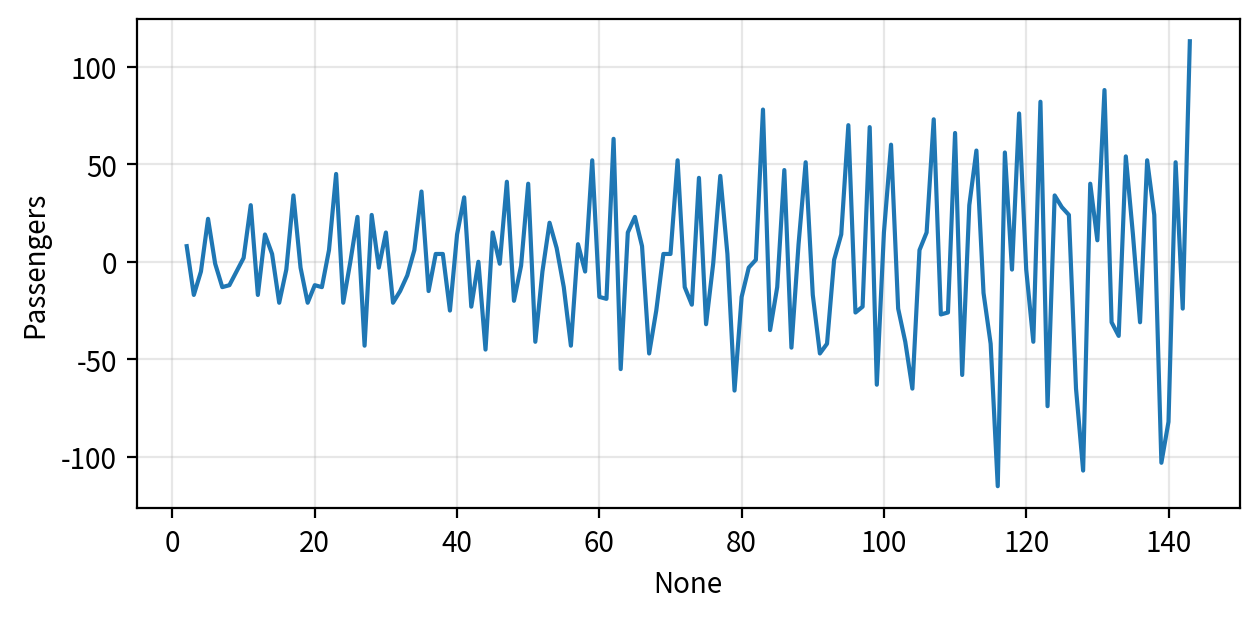

In [46]:
diff_df = origin.copy()
yname = 'Passengers'
diff_count = 0                      #몇 번까지  차분을 수행했는지 count
result = []                        # 결과를 저장할 빈 리스트

while True:
    ar = adfuller(diff_df[yname])

    ar_dict = {
        '차수': diff_count,
        'ADF Statistic':ar[0],
        'p-value':ar[1],
        'result':True if ar[1]<=0.05 else False
    
    }
    #리스트에 정상성 검사 결과를 저장
    result.append(ar_dict)
    
    #정상성 충족이라면 반복 중단
    if ar_dict['result']:
        break
    #정상성 충족되지 않았다면 차분 수행 후 다시 수행
    diff_count +=1
    diff_df =diff_df.diff().dropna()
    
#차분 결과표
display(DataFrame(result))

#차분의 결과로 생성된 데이터 프레임
display(diff_df.head())


#차분 결과 시각화
width_px = 1280
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.lineplot(data=diff_df, x=diff_df.index, y=yname)


ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()


    

# ACF 검정

In [47]:
#차분된 시계열의 자기상관 계수(acf) 계산(lag 0부터 시작)
acf_vals = acf(diff_df['Passengers'])

#ACF 유의성 판단 기준(근사적 95% 신뢰구간)
threshold = 2/ np.sqrt(len(diff_df['Passengers']))

#임계값을 초과하는 (유의한)lag 인덱스 추출
significant_lags = np.where(np.abs(acf_vals)>threshold)[0]

acf_vals, threshold, significant_lags

(array([ 1.        , -0.19100587, -0.19598169, -0.0485473 , -0.20664662,
         0.11939696,  0.02575129,  0.14558204, -0.22613908,  0.01407533,
        -0.2082756 , -0.12089977,  0.78224898, -0.09592873, -0.19547382,
        -0.07034343, -0.14794844,  0.11319557,  0.01921939,  0.13695131,
        -0.24015233,  0.02613065]),
 np.float64(0.16783627165933782),
 array([ 0,  1,  2,  4,  8, 10, 12, 14, 20]))

In [48]:
#ACF 계신
acf_vals = acf(diff_df['Passengers'])
threshold = 2/np.sqrt(len(diff_df['Passengers']))

# 결과표 생성
df_acf = DataFrame({
    "lag": np.arange(len(acf_vals)),
    "acf":acf_vals,

})

#유의성 판단

df_acf["abs_acf"] = df_acf["acf"].abs()
df_acf["significant"] = df_acf["abs_acf"]> threshold



df_acf["acf"] = df_acf["acf"].round(3)
df_acf["abs_acf"]=df_acf["abs_acf"].round(3)
df_acf["threshold"]=round(threshold,3)

#lag=0 제외 (판정용)
df_acf_result = df_acf.query("lag>0").reset_index(drop=True)

#연속 유의 구간 계산
df_acf_result["prev_significant"] = df_acf_result["significant"].shift(1)

df_acf_result["cut_candidate"] = (
    (df_acf_result["prev_significant"] == True)&
    (df_acf_result["significant"] == False)
)

df_acf_result[["lag", "acf", "significant", "cut_candidate"]]

df_acf_result

,lag,acf,abs_acf,significant,threshold,prev_significant,cut_candidate
0,1,-0.191,0.191,True,0.168,NaN,False
1,2,-0.196,0.196,True,0.168,True,False
2,3,-0.049,0.049,False,0.168,True,True
3,4,-0.207,0.207,True,0.168,False,False
4,5,0.119,0.119,False,0.168,True,True
5,6,0.026,0.026,False,0.168,False,False
6,7,0.146,0.146,False,0.168,False,False
7,8,-0.226,0.226,True,0.168,False,False
8,9,0.014,0.014,False,0.168,True,True
9,10,-0.208,0.208,True,0.168,False,False


# ACE PLOT

In [49]:
q_candidate = (
    df_acf_result
    .loc[df_acf_result["cut_candidate"], "lag"]
    .min() -1
)

q_candidate

np.int64(2)

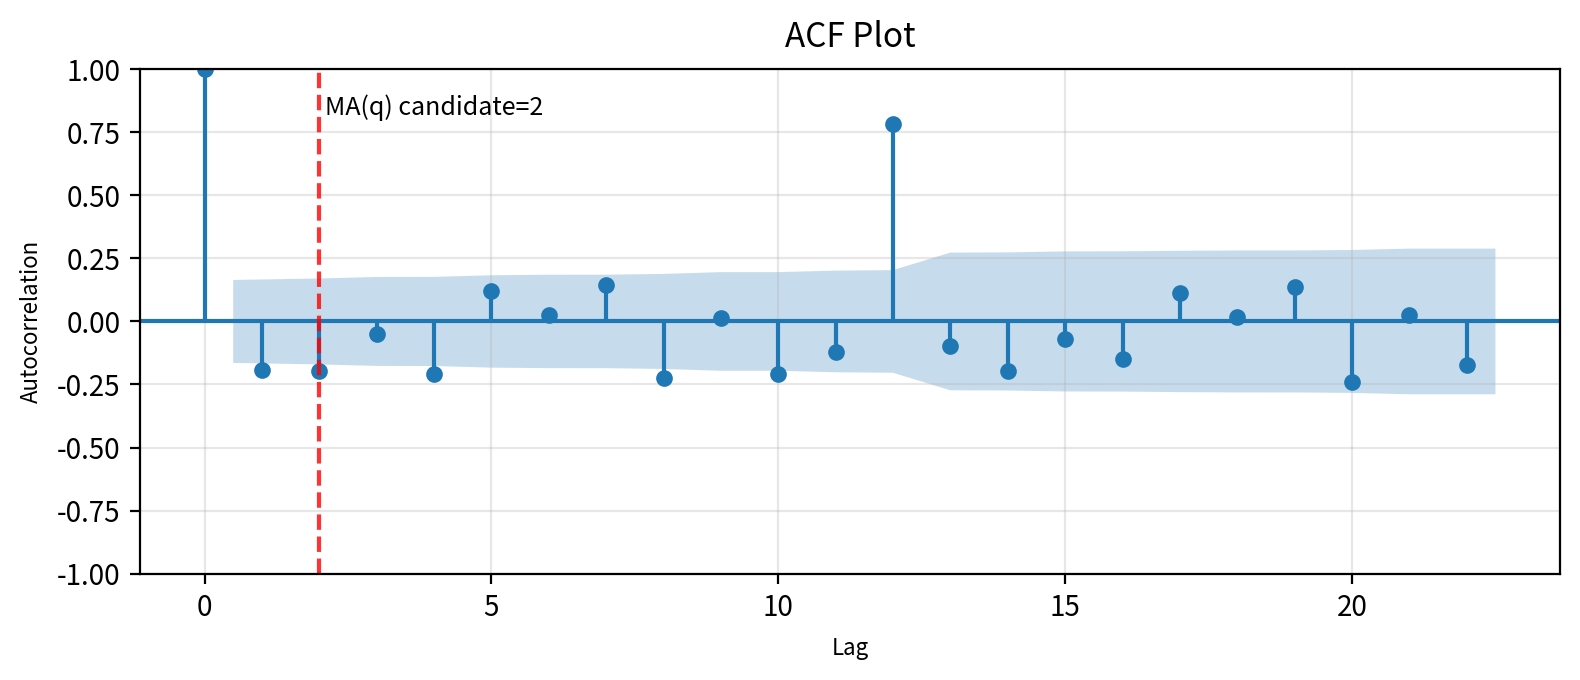

In [50]:
width_px = 1600
height_px = 700
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

#ACF Plot그리기->ax파라미터 필수
plot_acf(diff_df['Passengers'], ax=ax)

#MA(q)후보 시각화

ax.axvline(
    x=q_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color = 'red'
)
ax.text(
    q_candidate+0.1,
    ax.get_ylim()[1] * 0.9,
    f"MA(q) candidate={q_candidate}",
    fontsize=9,
    verticalalignment="top"
)
ax.set_title("ACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()
plt.close()

# PACF

In [51]:
#PACF 계산
pacf_vals = pacf(diff_df['Passengers'])
threshold = 2/np.sqrt(len(diff_df["Passengers"]))

# 결과표 생성
df_pacf = DataFrame({
    "lag": np.arange(len(pacf_vals)),
    "pacf":pacf_vals,
})
#유의성 판단
df_pacf["abs_pacf"] = df_pacf["pacf"].abs()
df_pacf["significant"] = df_pacf["abs_pacf"]> threshold

#보기 좋게 정리
df_pacf["pacf"] = df_pacf["pacf"].round(3)
df_pacf["abs_pacf"] = df_pacf["abs_pacf"].round(3)
df_pacf["threshold"] = round(threshold,3)

#lag=0 제외
df_pacf_result = df_pacf.query("lag>0").reset_index(drop=True)

#연속 유의구간 계산
df_pacf_result['prev_significant'] = df_pacf_result["significant"].shift(1)

df_pacf_result["cut_candidate"]=(
    (df_pacf_result["prev_significant"]==True)&
    (df_pacf_result["significant"]==False)
)
df_pacf_result[["lag", "pacf", "significant", "cut_candidate"]]
df_pacf_result

,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,-0.192,0.192,True,0.168,NaN,False
1,2,-0.245,0.245,True,0.168,True,False
2,3,-0.159,0.159,False,0.168,True,True
3,4,-0.355,0.355,True,0.168,False,False
4,5,-0.112,0.112,False,0.168,True,True
5,6,-0.169,0.169,True,0.168,False,False
6,7,0.078,0.078,False,0.168,True,True
7,8,-0.329,0.329,True,0.168,False,False
8,9,-0.075,0.075,False,0.168,True,True
9,10,-0.596,0.596,True,0.168,False,False


# PACF PLOT

In [52]:
p_candidate = (
    df_pacf_result
    .loc[df_pacf_result["cut_candidate"], "lag"]
    .min()-1
)
p_candidate

np.int64(2)

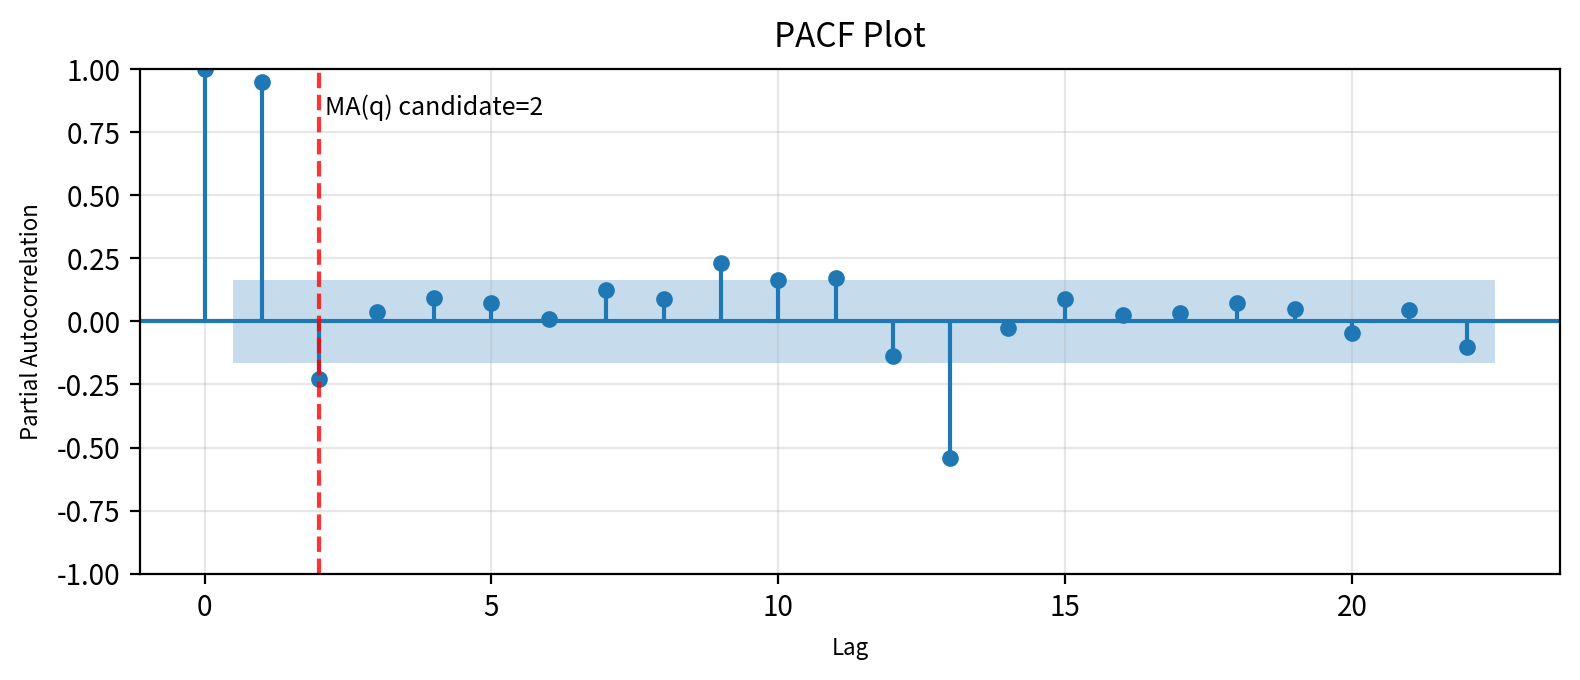

In [53]:
width_px = 1600
height_px = 700
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

#ACF Plot그리기->ax파라미터 필수
plot_pacf(origin['Passengers'], ax=ax)

#MA(q)후보 시각화

ax.axvline(
    x=p_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color = 'red'
)
ax.text(
    q_candidate+0.1,
    ax.get_ylim()[1] * 0.9,
    f"MA(q) candidate={p_candidate}",
    fontsize=9,
    verticalalignment="top"
)
ax.set_title("PACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Partial Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()
plt.close()